This notebook explores the two **Quarterly Census of Employment and Wages Annual Data** datasets from NYS Open Data
* 1975-2000: https://data.ny.gov/Economic-Development/Quarterly-Census-of-Employment-and-Wages-Annual-Da/shc7-xcbw
* 2000-2018: https://data.ny.gov/Economic-Development/Quarterly-Census-of-Employment-and-Wages-QCEW-Hist/ej35-turb

The difference is that the pre-2000 dataset uses SIC codes to classify industries, whereas the post 2000 dataset uses NAICS codes. I propose that we use just data from 2000 onwards since the conversion between SIC codes to NAICS codes is not straightforward. And perhaps we can try to find some ACS information to supplement the 1997-2000 gap. 

Inflation data: **CPI for All Urban Consumers (CPI-U)** from the US Bureau of Labor Statistics
* Source: https://data.bls.gov/PDQWeb/cu
* Metadata:
    * Series Id:     CUURS12ASA0,CUUSS12ASA0
    * Not Seasonally Adjusted
    * Series Title:  All items in New York-Newark-Jersey City, NY-NJ-PA, all urban consumers, not seasonally adjusted
    * Area:          New York-Newark-Jersey City, NY-NJ-PA
    * Item:          All items
    * Base Period:   1982-84=100
    
Instructions on calculating real wages: https://www.cpwr.com/sites/default/files/annex_how_to_calculate_the_real_wages.pdf

Done by: Angelia

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline

# file paths
ORI_QCEW_FILEPATH = '../data/QCEW_2000-2018.csv'
CLEANED_QCEW_SELECTED_IND_FILEPATH = '../data/QCEW_2000-2018_cleaned_selected_ind.csv'
CLEANED_QCEW_NAICS_SECTORS_FILEPATH = '../data/QCEW_2000-2018_cleaned_naics_sectors.csv'
NAICS_MAPPING_FILEPATH = '../data/QCEW_NAICS_mapping.csv'
NAICS_SECTOR_CODES_FILEPATH = '../data/naics_sector_codes.csv'
SELECTED_INDUSTRIES_FILEPATH = '../data/QCEW_potential_industries.csv'
WOH_OUT_FILEPATH = '../data/WOH_with_state_QCEW_and_adjusted.csv'
INFLATION_FILEPATH = '../data/CPI-for-All-Urban-Consumers_NY-NJ-PA_1997-2019.csv'

# constants
WOH_COUNTIES = ['Delaware', 'Greene', 'Schoharie',
                'Sullivan', 'Ulster']
EOH_COUNTIES = ['Dutchess', 'Putnam', 'Westchester']
NYC_COUNTIES = ['New York', 'Richmond', 'Kings',
                'Bronx', 'Queens']
METRICS = ['Real Average Salary', 'Real Total Salary', 'Average Employment', 'Establishments']

In [5]:
# get NAICS-Sectors only, per https://www.bls.gov/cew/classifications/industry/industry-supersectors.htm
qcew = pd.read_csv(ORI_QCEW_FILEPATH, index_col=0)
qcew['NAICS'] = qcew.NAICS.astype('str')
qcew.NAICS.nunique()

419

In [14]:
qcew.head()

,Area Type,Area,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary
0,County,Albany County,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0
1,County,Albany County,0,"Total, All Industries",2017,10263,233921,1.325479e+10,56664.0
2,County,Albany County,0,"Total, All Industries",2016,10203,232428,1.288220e+10,55424.0
3,County,Albany County,0,"Total, All Industries",2015,10212,229783,1.246205e+10,54234.0
4,County,Albany County,0,"Total, All Industries",2014,10094,225216,1.190129e+10,52844.0


#### Different selections of NAICS codes

In [20]:
# output to csv the naics sector codes, 
# as defined under QCEW High-Level Industry Crosswalk
# from https://www.bls.gov/cew/classifications/industry/industry-supersectors.htm
naics_sectors = [x for x in qcew.NAICS.unique() if len(x)<=2]
qcew[(qcew.NAICS.isin(naics_sectors)) & (qcew['Area Type']=='County')]\
    [['NAICS', 'NAICS Title']]\
    .drop_duplicates()\
    .set_index('NAICS')\
    .to_csv(NAICS_SECTOR_CODES_FILEPATH)

In [3]:
# output the mapping between NAICS code and associated title
qcew[qcew['Area Type']=='County'][['NAICS', 'NAICS Title']]\
    .drop_duplicates()\
    .set_index('NAICS')\
    .to_csv(NAICS_MAPPING_FILEPATH)

#### Reading the data

In [23]:
# reading datasets
selected_ind = pd.read_csv(SELECTED_INDUSTRIES_FILEPATH, index_col='NAICS') # manually selected industries
naics_sectors = pd.read_csv(NAICS_SECTOR_CODES_FILEPATH, index_col='NAICS') # naics sectors ie codes that are 2-digit
inflation = pd.read_csv(INFLATION_FILEPATH, index_col='year')
qcew = pd.read_csv(ORI_QCEW_FILEPATH, index_col=0)

# 1. Adjust salary metrics with CPI

In [24]:
### filter data before data transformation, to reduce number of computations
# different filters: seleected_ind or naics_sectors
qcew = qcew[(qcew.NAICS.isin(naics_sectors.index)) 
            & (qcew['Area Type']=='County')] 

In [25]:
# adjust avg salary
qcew = qcew.merge(inflation, left_on='Year', right_index=True) # add cpi info
latest_cpi = inflation[inflation.index==qcew.Year.max()].cpi.tolist()[0]
qcew['Real Average Salary'] = qcew.apply(lambda row: (row['Annual Average Salary']*latest_cpi)/row.cpi, 
                                         axis=1)
qcew['Real Total Salary'] = qcew.apply(lambda row: (row['Total Wage']*latest_cpi)/row.cpi, 
                                         axis=1)
qcew.head(3)

,Area Type,Area,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,cpi,Real Average Salary,Real Total Salary
0,County,Albany County,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0,273.641,58282.0,1.361919e+10
19,County,Albany County,1,"Total, All Private",2018,9813,172969,9.545942e+09,55189.0,273.641,55189.0,9.545942e+09
38,County,Albany County,11,"Agriculture, Forestry, Fishing and Hunting",2018,17,235,7.986065e+06,33983.0,273.641,33983.0,7.986065e+06


In [26]:
# format df and save as csv
qcew_cleaned = qcew.drop(columns='Area Type')
qcew_cleaned = qcew_cleaned.rename(columns={'Area': 'County', 'cpi': 'CPI'})
qcew_cleaned['County'] = qcew_cleaned.County.str.replace(' County', '')
qcew_cleaned = qcew_cleaned.set_index('County')
qcew_cleaned.head(3)

,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,CPI,Real Average Salary,Real Total Salary
County,,,,,,,,,,
Albany,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0,273.641,58282.0,1.361919e+10
Albany,1,"Total, All Private",2018,9813,172969,9.545942e+09,55189.0,273.641,55189.0,9.545942e+09
Albany,11,"Agriculture, Forestry, Fishing and Hunting",2018,17,235,7.986065e+06,33983.0,273.641,33983.0,7.986065e+06


In [28]:
qcew_cleaned.to_csv(CLEANED_QCEW_NAICS_SECTORS_FILEPATH)
# qcew_cleaned.to_csv(CLEANED_QCEW_SELECTED_IND_FILEPATH)

# 2. Analyzing the 2000-2018 dataset

In [2]:
qcew = pd.read_csv(CLEANED_QCEW_NAICS_SECTORS_FILEPATH)
qcew.head(3)

,County,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,CPI,Real Average Salary,Real Total Salary
0,Albany,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0,273.641,58282.0,1.361919e+10
1,Albany,1,"Total, All Private",2018,9813,172969,9.545942e+09,55189.0,273.641,55189.0,9.545942e+09
2,Albany,11,"Agriculture, Forestry, Fishing and Hunting",2018,17,235,7.986065e+06,33983.0,273.641,33983.0,7.986065e+06


In [3]:
REGION_CMAP = {
    'EOH Counties': 'teal',
    'WOH Counties': 'orange', 
    'NYC Counties': 'purple', 
    'Other Counties': 'lightgrey',
    'State Average': 'salmon',
    'State Median': 'deepskyblue'
}
STATE_AVG = 'State Average'
STATE_MEDIAN = 'State Median'

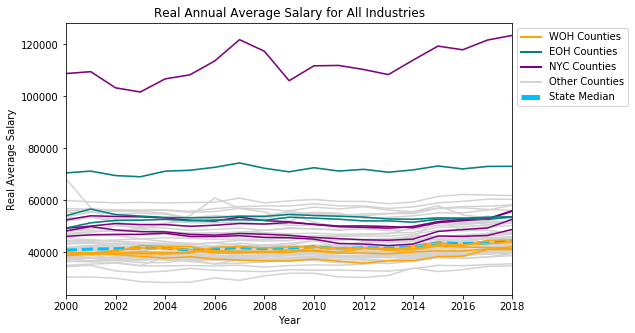

In [51]:
# plot Real Avg Salary across 'Total, All Industries', for all counties
temp = qcew[qcew['NAICS Title']=='Total, All Industries']\
    .pivot(index='Year',
           columns='County',
           values='Real Average Salary')
temp[STATE_MEDIAN] = temp.median(axis=1)

# plot lines
_, ax = plt.subplots(figsize=(8,5))
temp.plot(ax=ax, color=REGION_CMAP['Other Counties'])
temp[STATE_MEDIAN].plot(ax=ax, color=REGION_CMAP[STATE_MEDIAN], 
                           linewidth=3, linestyle='--')
temp[NYC_COUNTIES].plot(ax=ax, color=REGION_CMAP['NYC Counties'])
temp[WOH_COUNTIES].plot(ax=ax, color=REGION_CMAP['WOH Counties'])
temp[EOH_COUNTIES].plot(ax=ax, color=REGION_CMAP['EOH Counties'])

# custom legend
legend_order = ['WOH Counties', 'EOH Counties', 'NYC Counties', 'Other Counties']
custom_lines = [Line2D([0], [0], color=REGION_CMAP[x], lw=2) for x in legend_order] + \
    [Line2D([0], [0], color=REGION_CMAP[STATE_MEDIAN], linewidth=5, linestyle='--')]

ax.legend(custom_lines, legend_order+[STATE_MEDIAN], bbox_to_anchor=(1, 1))
plt.ylabel('Real Average Salary')
_ = plt.title('Real Annual Average Salary for All Industries')

Text(0, 0.5, 'Adjusted Avg Salary')

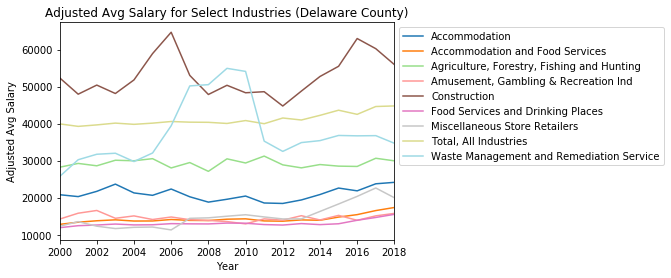

In [31]:
qcew = pd.read_csv(CLEANED_QCEW_SELECTED_IND_FILEPATH)

# plot all industries for Delaware County
ind_to_keep = ['Accommodation', 'Agriculture, Forestry, Fishing and Hunting', 
               'Construction', 'Waste Management and Remediation Service']
temp = qcew[qcew.County=='Delaware']\
    .pivot_table(index='Year',
           columns='NAICS Title',
           values='Real Average Salary')\
    .dropna(axis=1)
temp = temp.loc[:, (temp.iloc[-1] - temp.iloc[0])>=0]
ax = temp.plot(cmap='tab20', 
          title='Adjusted Avg Salary for Select Industries (Delaware County)')
ax.legend(bbox_to_anchor=(1,1))
ax.set_ylabel('Adjusted Avg Salary')

In [6]:
# investigate Healthcare sector since it appears to increase in 
# real total salary across all the counties
hc = qcew[qcew['NAICS Title'] == 'Health Care and Social Assistance']
hc.head(2)

,County,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,CPI,Real Average Salary,Real Total Salary
16,Albany,62,Health Care and Social Assistance,2018,947,33768,1.673688e+09,49564.0,273.641,49564.0,1.673688e+09
39,Allegany,62,Health Care and Social Assistance,2018,96,1479,4.812914e+07,32542.0,273.641,32542.0,4.812914e+07


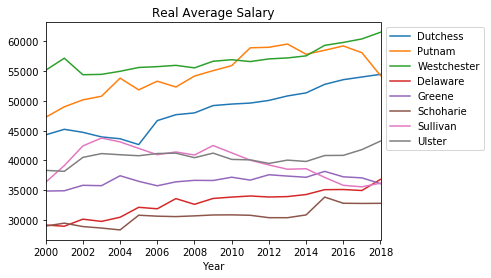

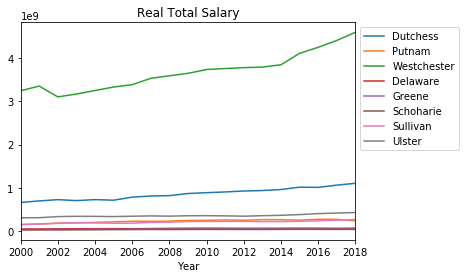

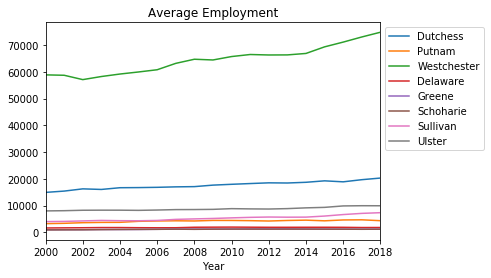

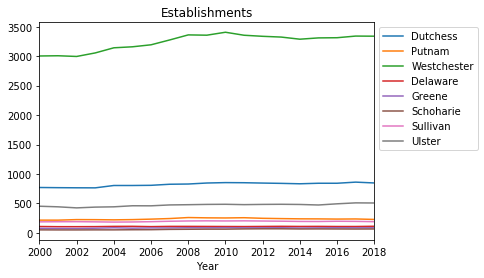

In [14]:
for metric in METRICS:
    hc.pivot_table(index='Year',
                   columns='County', 
                   values=metric)\
        [EOH_COUNTIES+WOH_COUNTIES]\
        .plot()
    plt.legend(bbox_to_anchor=(1,1))
    plt.title(metric)

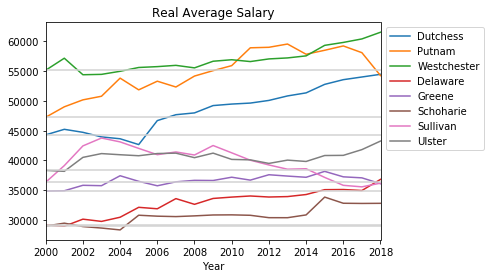

In [23]:
metric = 'Real Average Salary'
hc_ras = hc.pivot_table(index='Year',
               columns='County', 
               values=metric)\
        [EOH_COUNTIES+WOH_COUNTIES]
hc_ras.plot()
plt.legend(bbox_to_anchor=(1,1))
plt.title(metric)
for starting_salary in hc_ras.iloc[0,:].tolist():
    plt.axhline(starting_salary, color='lightgrey')

Text(0.5, 1.0, 'Real Average Salary (All Counties)')

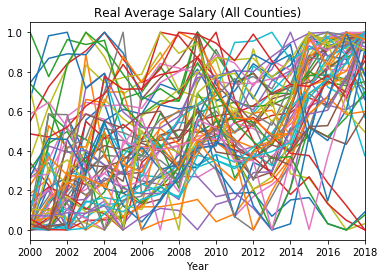

In [31]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

metric = 'Real Average Salary'
hc_ras = hc.pivot_table(index='Year',
               columns='County', 
               values=metric)
hc_ras = pd.DataFrame(scaler.fit_transform(hc_ras.values), 
                      index=hc_ras.index, 
                      columns=hc_ras.columns)
# hc_ras.values
hc_ras.plot(legend=False)
plt.title(metric + ' (All Counties)')

## Distribution by industries

In [32]:
qcew = pd.read_csv(CLEANED_QCEW_NAICS_SECTORS_FILEPATH)
qcew.columns

Index(['County', 'NAICS', 'NAICS Title', 'Year', 'Establishments',
       'Average Employment', 'Total Wage', 'Annual Average Salary', 'CPI',
       'Real Average Salary', 'Real Total Salary'],
      dtype='object')

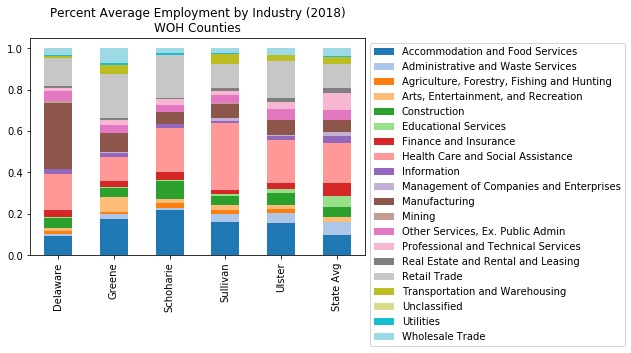

In [84]:
# example: woh counties, of year 2018

# distribution of avg employment per industry
emp_dist = qcew[(qcew.Year==2018) 
     & (qcew.County.isin(WOH_COUNTIES))
     & ~(qcew.NAICS.isin([0,1,95]))]\
    .pivot_table(columns='NAICS Title', 
                 index='County', 
                 values='Average Employment')
emp_dist = emp_dist.div(emp_dist.sum(axis=1), axis=0) # transform to percentages

# compute state average
emp_dist_state_avg = qcew[(qcew.Year==2018) 
     & ~(qcew.NAICS.isin([0,1,95]))]\
    .pivot_table(columns='NAICS Title', 
                 index='County', 
                 values='Average Employment')\
    .mean()

# add state average to woh-only df
emp_dist = pd.concat([emp_dist,
          emp_dist_state_avg.div(emp_dist_state_avg.sum(), axis=0)\
            .to_frame('State Avg')\
            .transpose()])

# plot
emp_dist.plot.bar(stacked=True,
                  cmap='tab20',
                  title='Percent Average Employment by Industry (2018)\nWOH Counties')
_ = plt.legend(bbox_to_anchor=(1,1))

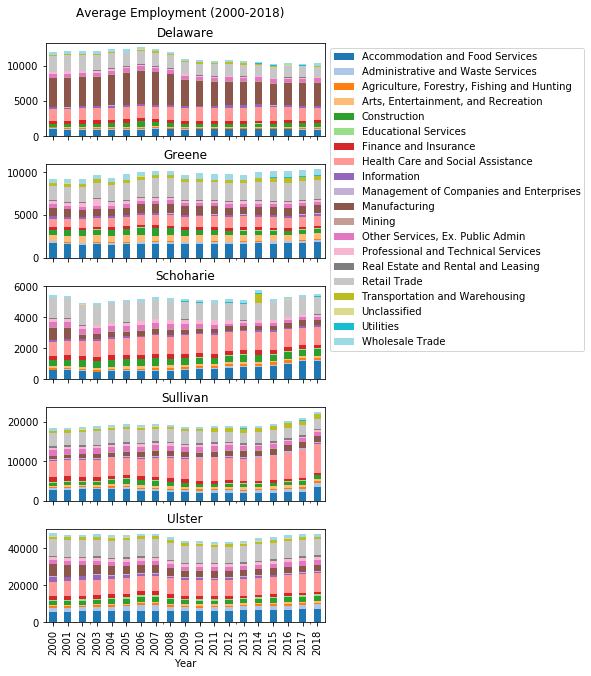

In [101]:
_, axes = plt.subplots(len(WOH_COUNTIES), sharex=True, figsize=(5,10))
for i, county in enumerate(WOH_COUNTIES):
    county_df = qcew[(qcew.County==county)
                    & ~(qcew.NAICS.isin([0,1,95]))]\
        .pivot_table(index='Year',
                     columns='NAICS Title',
                     values='Average Employment')

    # plot
    county_df.plot.bar(ax=axes[i],
                       stacked=True,
                       cmap='tab20',
                       title=county,
                       legend=False,
                      )
axes[0].legend(bbox_to_anchor=(1,1))
plt.suptitle('Average Employment (2000-2018)')
plt.subplots_adjust(hspace=.3, top=.93)

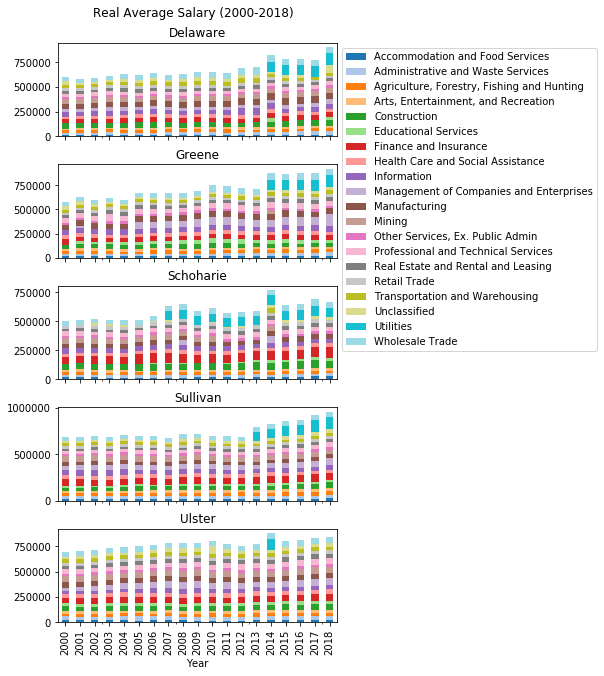

In [103]:
_, axes = plt.subplots(len(WOH_COUNTIES), sharex=True, figsize=(5,10))
for i, county in enumerate(WOH_COUNTIES):
    county_df = qcew[(qcew.County==county)
                    & ~(qcew.NAICS.isin([0,1,95]))]\
        .pivot_table(index='Year',
                     columns='NAICS Title',
                     values='Real Average Salary')

    # plot
    county_df.plot.bar(ax=axes[i],
                       stacked=True,
                       cmap='tab20',
                       title=county,
                       legend=False,
                      )
axes[0].legend(bbox_to_anchor=(1,1))
plt.suptitle('Real Average Salary (2000-2018)')
plt.subplots_adjust(hspace=.3, top=.93)

# Export as json

In [2]:
QCEW_FILEPATH = '../data/QCEW_2000-2018_cleaned_naics_sectors.csv'
METRICS = ['Real Average Salary', 'Average Employment', 'Establishments']
df = pd.read_csv(QCEW_FILEPATH)
df.head()

,County,NAICS,NAICS Title,Year,Establishments,Average Employment,Total Wage,Annual Average Salary,CPI,Real Average Salary,Real Total Salary
0,Albany,0,"Total, All Industries",2018,10252,233679,1.361919e+10,58282.0,273.641,58282.0,1.361919e+10
1,Albany,1,"Total, All Private",2018,9813,172969,9.545942e+09,55189.0,273.641,55189.0,9.545942e+09
2,Albany,11,"Agriculture, Forestry, Fishing and Hunting",2018,17,235,7.986065e+06,33983.0,273.641,33983.0,7.986065e+06
3,Albany,22,Utilities,2018,11,520,6.750030e+07,129808.0,273.641,129808.0,6.750030e+07
4,Albany,23,Construction,2018,696,7554,5.878178e+08,77815.0,273.641,77815.0,5.878178e+08


In [3]:
data = {}
for metric in METRICS: 
    data[metric] = {}
    for county in WOH_COUNTIES+EOH_COUNTIES:
        data[metric][county] = {}
        for industry in df['NAICS Title'].unique():
            data[metric][county][industry] = df[(df.County==county)
                                                &(df['NAICS Title']==industry)]\
                                                    .set_index('Year')[metric]\
                                                    .to_dict()

In [4]:
import json
with open('../output/qcew.json', 'w') as f:
    json.dump(data, f)